# Load Variance Problem
## Import Dependencies

In [73]:
 %load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline
from IPython.display import set_matplotlib_formats
%config InlineBackend.figure_format='svg'
import seaborn
seaborn.reset_orig()
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 4

import itertools
import numpy as np
from numpy import inf
from numpy.linalg import norm
from optalg.opt_solver import *
import scipy.io # to read matlab files
from mppfnet.mp_network import MPNetwork
from mppfnet.mp_problem import MPProblem
import mppfnet
import gridopt
import pfnet
import multiprocessing
from scipy.sparse import triu,coo_matrix,bmat,eye

import cvxpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


## Construct Problem

In [75]:
mp = MPNetwork(timesteps=24)
mp.load('./data/case32.art')

In [76]:
prices = scipy.io.loadmat('./data/eex_intraday_2010_3600s.mat')['eex_intraday_2010_3600s']
eex_prices = np.array([p[0,0] for p in prices[:, 5][1:]])
mp.set_prices(eex_prices)

In [77]:
mp.load_load_profile_from_csv("./data/Electricity_Profile.csv")

In [78]:
mp.generate_solar_profiles()

In [79]:
mp.set_flags(pfnet.OBJ_BAT, pfnet.FLAG_VARS,pfnet.BAT_PROP_ANY, pfnet.BAT_VAR_E)
mp.set_flags(pfnet.OBJ_BAT, pfnet.FLAG_VARS,pfnet.BAT_PROP_ANY, pfnet.BAT_VAR_P)
mp.set_flags(pfnet.OBJ_GEN, pfnet.FLAG_VARS, pfnet.GEN_PROP_NOT_SLACK,pfnet.GEN_VAR_P)
mp.set_flags(pfnet.OBJ_GEN, pfnet.FLAG_VARS, pfnet.GEN_PROP_SLACK,pfnet.GEN_VAR_P)
mp.set_flags(pfnet.OBJ_GEN,pfnet.FLAG_BOUNDED,pfnet.GEN_PROP_ANY,pfnet.GEN_VAR_P)
mp.set_flags(pfnet.OBJ_BAT,pfnet.FLAG_BOUNDED,pfnet.BAT_PROP_ANY,pfnet.BAT_VAR_P)
mp.set_flags(pfnet.OBJ_BAT,pfnet.FLAG_BOUNDED,pfnet.BAT_PROP_ANY,pfnet.BAT_VAR_E)

In [80]:
p = MPProblem(mp)

In [81]:
p.add_function(pfnet.FUNC_TYPE_NETCON_COST, 1.0)

In [82]:
p.add_constraint(pfnet.CONSTR_TYPE_LBOUND)
p.add_constraint(mppfnet.CONSTR_TYPE_BAT_DYN)

In [83]:
p.analyze()
x = p.get_init_point()
x = p.eval(x)

## Construct CVXPY Problem

In [84]:
x = cvxpy.Variable(mp.get_network().num_vars * mp.timesteps)

In [85]:
constraints = []
constraints += [p.A * x == p.b]
constraints += [ p.l <= x, x <= p.u]

Tuning parameter $\gamma$ that scales the penalty of a spiky load profile. A lower $\gamma$ corresponds to a less spiky load profile.

In [266]:
gamma = 1e-6

In [267]:
Hx = p.Hphi + p.Hphi.T - triu(p.Hphi)
gx = p.gphi - Hx*x
g = gx / mp.base_power
energy_cost_obj = g.T * x # energy cost

In [268]:
net_power = dict()
for t in range(0, mp.timesteps):
    net_power[t] = 0.0
    for bus_i in mp.get_network().buses:        
        i = bus_i.index
        net_power[t] += sum([load.P for load in mp.get_network(time=t).get_bus(i).loads]) # load power
        net_power[t] -= sum([vargens.P for vargens in mp.get_network(time=t).get_bus(i).vargens]) # vargen power
        net_power[t] -= sum([gens.P for gens in mp.get_network(time=t).get_bus(i).gens]) # gen power
        net_power[t] += sum([x[t * mp.get_network().num_vars + bat.index_Pc] for bat in mp.get_network(time=t).get_bus(i).bats]) # battery charge
        net_power[t] -= sum([x[t * mp.get_network().num_vars + bat.index_Pd] for bat in mp.get_network(time=t).get_bus(i).bats]) # battery discharge
        
profile_smothing_obj += sum([cvxpy.norm(net_power[t] - net_power[t-1]) for t in range(1, mp.timesteps)])

In [269]:
obj = profile_smothing_obj + gamma * energy_cost_obj

In [270]:
problem = cvxpy.Problem(cvxpy.Minimize(obj), constraints)

In [271]:
problem.solve()

9.173504370937238

## Map Solution

In [272]:
mp.set_var_values(np.array(x.value).flatten())
mp.update_properties()

## Display Results

In [273]:
%aimport pfvis

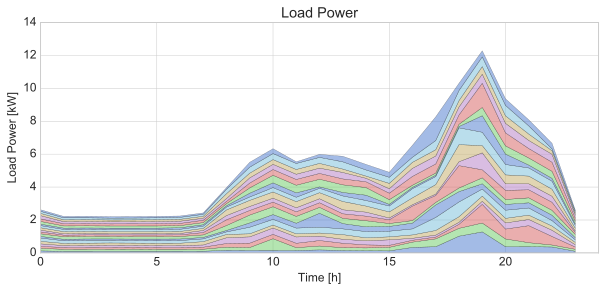

In [274]:
pfvis.plot_load_power(mp)

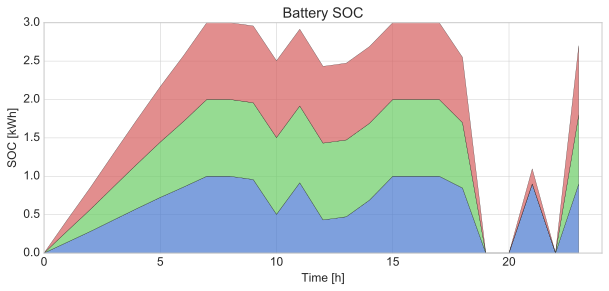

In [275]:
pfvis.plot_battery_soc(mp)

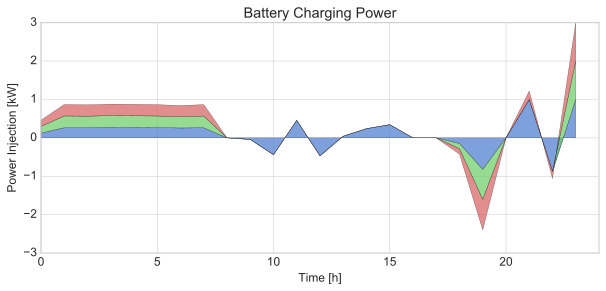

In [276]:
pfvis.plot_battery_power(mp)

In [277]:
agg_power = np.zeros(mp.timesteps)
battery_power  = np.zeros(mp.timesteps)
load_power  = np.zeros(mp.timesteps)
gen_power = np.zeros(mp.timesteps)
renewable_power  = np.zeros(mp.timesteps)
net_power_value  = np.zeros(mp.timesteps)

for t in range(mp.timesteps):
    net = mp.get_network(time=t)
    load_power[t] = sum(load.P for load in net.loads)
    gen_power[t] -= sum(gen.P for gen in net.generators)  
    renewable_power[t] -= sum(gen.P for gen in net.var_generators)
    battery_power[t] += sum(bat.P for bat in net.batteries) 
    net_power_value[t] = net_power[t] if isinstance(net_power[t], float) else net_power[t].value
    
delta_net_power = [net_power_value[t] - net_power_value[t-1] for t in range(mp.timesteps)]    

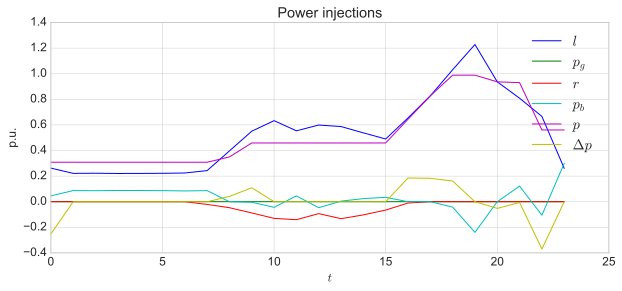

In [278]:
plot(load_power, label="$l$")
plot(gen_power, label="$p_g$")
plot(renewable_power, label="$r$")
plot(battery_power, label="$p_b$")
plot(net_power_value, label="$p$")
plot(delta_net_power, label="$\Delta p$ ")
title("Power injections")
xlabel("$t$")
ylabel("p.u.")

legend()
show()

Energy Cost

In [279]:
energy_cost_obj.value * gamma

0.0010905691164470577

Load profile penalty

In [280]:
profile_smothing_obj.value

9.1724138006905243